In [103]:
!which python

python not found


In [104]:
from pathlib import Path
import yaml
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from joblib import dump, load
from box import ConfigBox
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_auc_score , accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [105]:
def load_params(params_path):
    with open(params_path, "r") as f:
        params = yaml.safe_load(f)
        params = ConfigBox(params)
    return params

In [106]:
params = load_params('params.yaml')
params

ConfigBox({'base': {'project': 'bank_customer_churn', 'data_dir': 'data', 'data_fname': 'Churn_Modelling.csv', 'cat_cols': [], 'num_cols': ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'], 'targ_col': 'Exited', 'random_state': 42}, 'data_split': {'test_size': 0.25}, 'train': {'models_dir': 'models', 'model_fname': 'model.joblib', 'model_type': 'random-forest', 'params': {'n_estimators': 150, 'max_depth': 50}}})

In [107]:
params.base.data_dir

'data'

In [108]:
churn_filepath = Path(params.base.data_dir)/params.base.data_fname
churn_filepath

PosixPath('data/Churn_Modelling.csv')

In [109]:
df = pd.read_csv(churn_filepath)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [110]:
df.shape

(10000, 14)

In [111]:
cat_cols = params.base.cat_cols
num_cols = params.base.num_cols
targ_col = params.base.targ_col

cat_cols, num_cols, targ_col

(BoxList([]),
 BoxList(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']),
 'Exited')

In [112]:
X, y = df[cat_cols + num_cols], df[targ_col]

In [113]:
y.mean()

0.2037

In [114]:
test_size=params.data_split.test_size
random_state=params.base.random_state

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size, 
                                                    random_state=random_state)

In [115]:
### Implement Class imbalance 
### If we don´t balance the class the models will do little more than predict the most common class 

over = SMOTE(sampling_strategy='auto', random_state = random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

In [116]:
### See the balanced class 
y_train.value_counts()

1    5960
0    5960
Name: Exited, dtype: int64

In [117]:
train_params = params.train.params
model_type = params.train.model_type
if model_type == 'random-forest':
    clf = RandomForestClassifier(random_state=random_state, **train_params)
elif model_type == 'lightgbm':
    clf = LGBMClassifier(random_state=random_state, **train_params)
else:
    raise Exception('Unsupported model_type')
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, n_estimators=150, random_state=42)

In [118]:
Path(params.train.models_dir).mkdir(exist_ok=True)
dump(clf, Path(params.train.models_dir)/params.train.model_fname)

['models/model.joblib']

In [119]:
clf = load(Path(params.train.models_dir)/params.train.model_fname)

/Users/gema/Documents/demo-bank-customer-churn/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


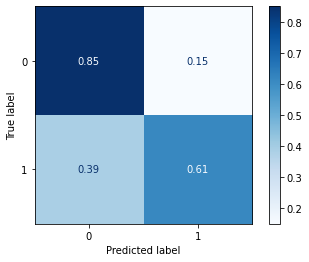

In [120]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)
plt.savefig(Path('eval_plots')/'cm.png')

In [121]:
y_prob = clf.predict_proba(X_test)
y_pred = y_prob[:, 1] >= 0.5

In [122]:
from dvclive import Live
live = Live("eval_plots")
live.log_plot("roc", y_test, y_prob[:, 1])

INFO:dvclive:Report path (if generated): /Users/gema/Documents/demo-bank-customer-churn/eval_plots/report.html


In [123]:
#clf ## Classifier
acc = accuracy_score(y_test, y_pred)


precision = precision_score(y_test, y_pred, average= 'binary')
recall = recall_score(y_test, y_pred, average='binary')

In [124]:
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob[:, 1])
metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        
        
    }
metrics

{'f1': 0.5532676812891675, 'roc_auc': 0.8222600706585996, 'accuracy': 0.8004}

In [125]:
json.dump(
    obj=metrics,
    fp=open('metrics.json', 'w'),
    indent=4, 
    sort_keys=True
)